### SIGW inverse problem with the full numerical integration for early matter to radiation transition

In [1]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
from interpax import CubicSpline
import numpyro
import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
from jaxns import NestedSampler
from jaxns import TerminationCondition, resample
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import Fixed_Nodes_Model, spline_predict
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


INFO:2025-02-19 17:10:04,115:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-02-19 17:10:04,125:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/cosmo/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Crypt

#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

(40,)


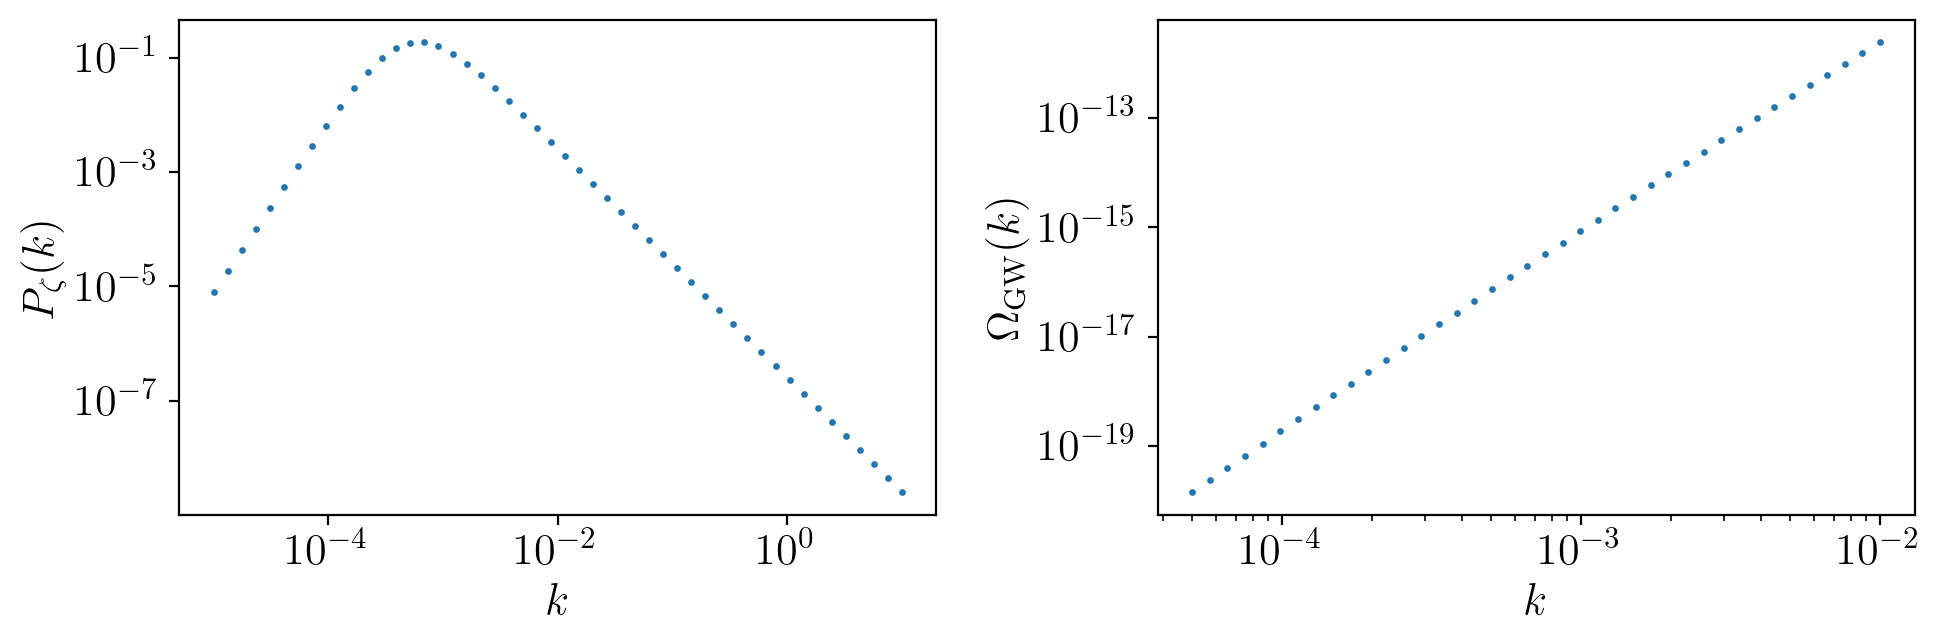

In [2]:
# set up the power spectrum and omgw
psize = 50
ksize = 40
k_arr = jnp.geomspace(5e-5,1e-2,ksize)
p_arr = jnp.geomspace(1e-5,1e1,psize)


f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

pstar=5e-4
n1=3
n2=-2
sigma=2

@jit
def pz(p,kmax,etaR):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="I_MD_to_RD", upsample=False,norm="CT")

kmax = 5e-2
etaR = 1./kmax
transition_params = [kmax,etaR]

pz_amp = pz(p_arr,*transition_params)
gwb_amp = gwb_calculator(pz,f,*transition_params)

print(gwb_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,gwb_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

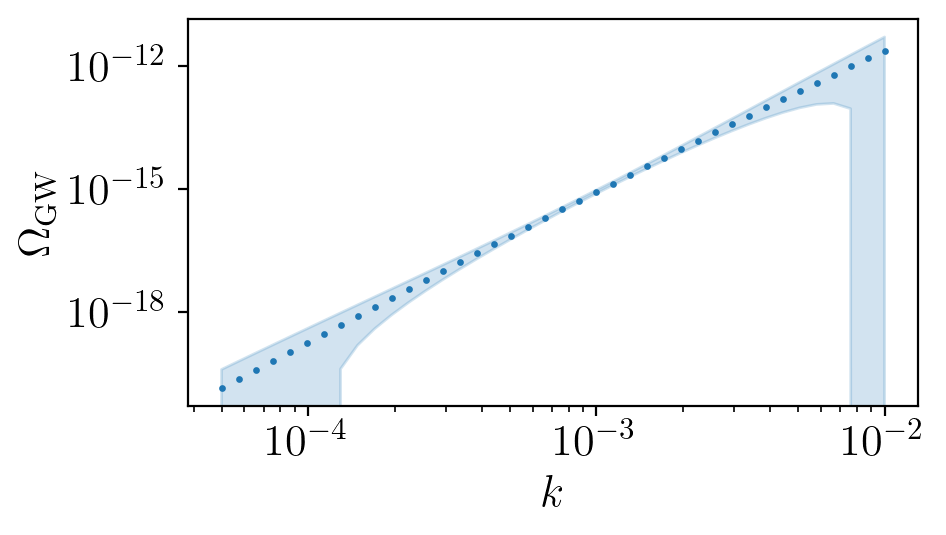

In [3]:
kstar = 1e-3
omks_sigma = gwb_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,gwb_amp,s=2)
ax.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [12]:
# define the splines

def pow10(x):
    return jnp.power(10,x)

def log10(x):
    return jnp.log10(x)

@jit
def spline_predict_log(x_train,y_train,x_pred):
    """
    Cubic spline to interpolate log10 P_zeta as a function of log10_k
    """
    spl = CubicSpline(x_train,y_train,check=False)
    y_pred = spl(x_pred)
    return y_pred

@jit
def spline_predict(x_train,y_train,x_pred):
    """
    Obtain spline prediction after exponentiating log10 P_zeta spline. 
    """
    x_pred = log10(x_pred)
    return pow10(spline_predict_log(x_train,y_train,x_pred))

# define the loss function for the interpolation

nodes = log10(jnp.geomspace(min(p_arr),max(p_arr),5))

omgw_calculator = OmegaGWjax(s, t, f=f, kernel="I_MD_to_RD", upsample=False,norm="CT")

y_low = -8 * jnp.ones(len(nodes))
y_high = 2 * jnp.ones(len(nodes))
kmax_low = -2
kmax_high = 0.

lows = jnp.concatenate([y_low,jnp.array([kmax_low])])
highs = jnp.concatenate([y_high,jnp.array([kmax_high])])

def logp(params):
    kmax = 10**params[-1]
    etaR = 1./kmax
    y = params[:-1]
    pz_interp = lambda k, kmax,etaR: spline_predict(x_train=nodes,y_train=y,x_pred=k)
    gwb = omgw_calculator(pz_interp,f,kmax,etaR)
    return -jnp.sum((gwb-gwb_amp)**2 / omks_sigma**2)
     
def prior_model():
    x = yield Prior(tfpd.Uniform(low=lows, high=highs), name='x')
    return x

model = Model(
    prior_model=prior_model,
    log_likelihood=logp
)

params = model.params

print(params)

model.sanity_check(random.PRNGKey(42), 1000)


{}


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [14]:
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True, difficult_model=False)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 711693
samples: 27270
phantom samples: 23220
likelihood evals / sample: 26.1
phantom fraction (%): 85.1%
--------
logZ=-19.74 +- 0.41
max(logL)=-0.0
H=-17.25
ESS=377
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: -1.7 +- 1.3 | -3.8 / -1.1 / -0.5 | -0.9 | -0.9
x[1]: 1.56 +- 0.31 | 1.13 / 1.63 / 1.9 | 1.61 | 1.61
x[2]: -0.14 +- 0.42 | -0.49 / -0.33 / 0.61 | -0.62 | -0.62
x[3]: -3.13 +- 0.44 | -3.5 / -3.33 / -2.37 | -3.66 | -3.66
x[4]: -6.19 +- 0.52 | -6.75 / -6.32 / -5.37 | -6.79 | -6.79
x[5]: -0.65 +- 0.12 | -0.75 / -0.7 / -0.45 | -0.79 | -0.79
--------


/opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


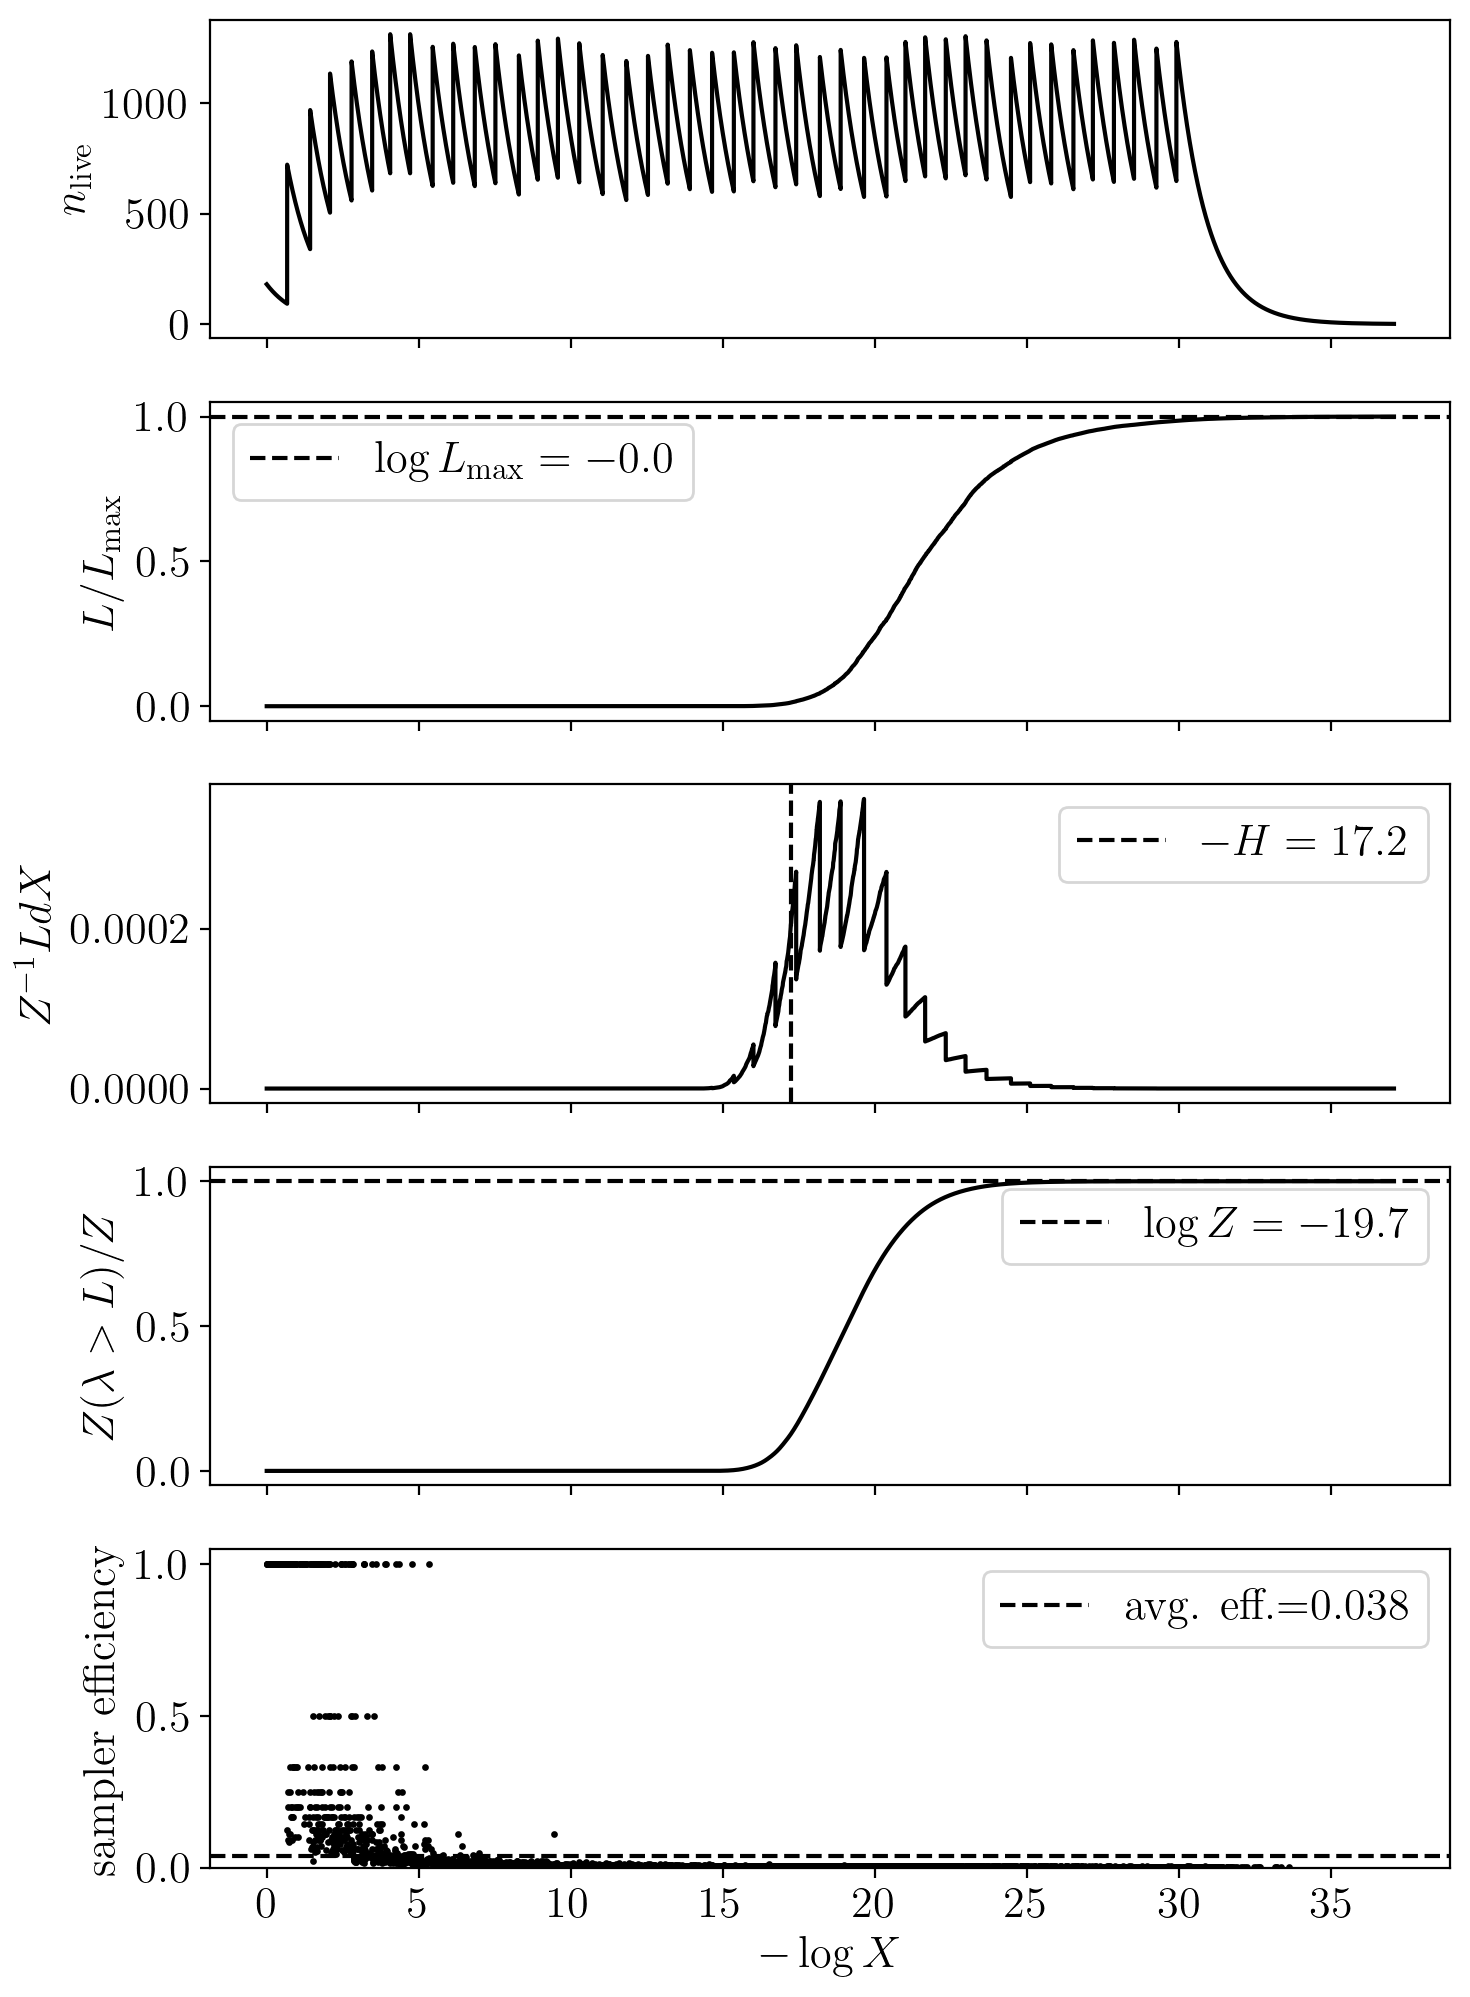

In [15]:
ns.plot_diagnostics(results)

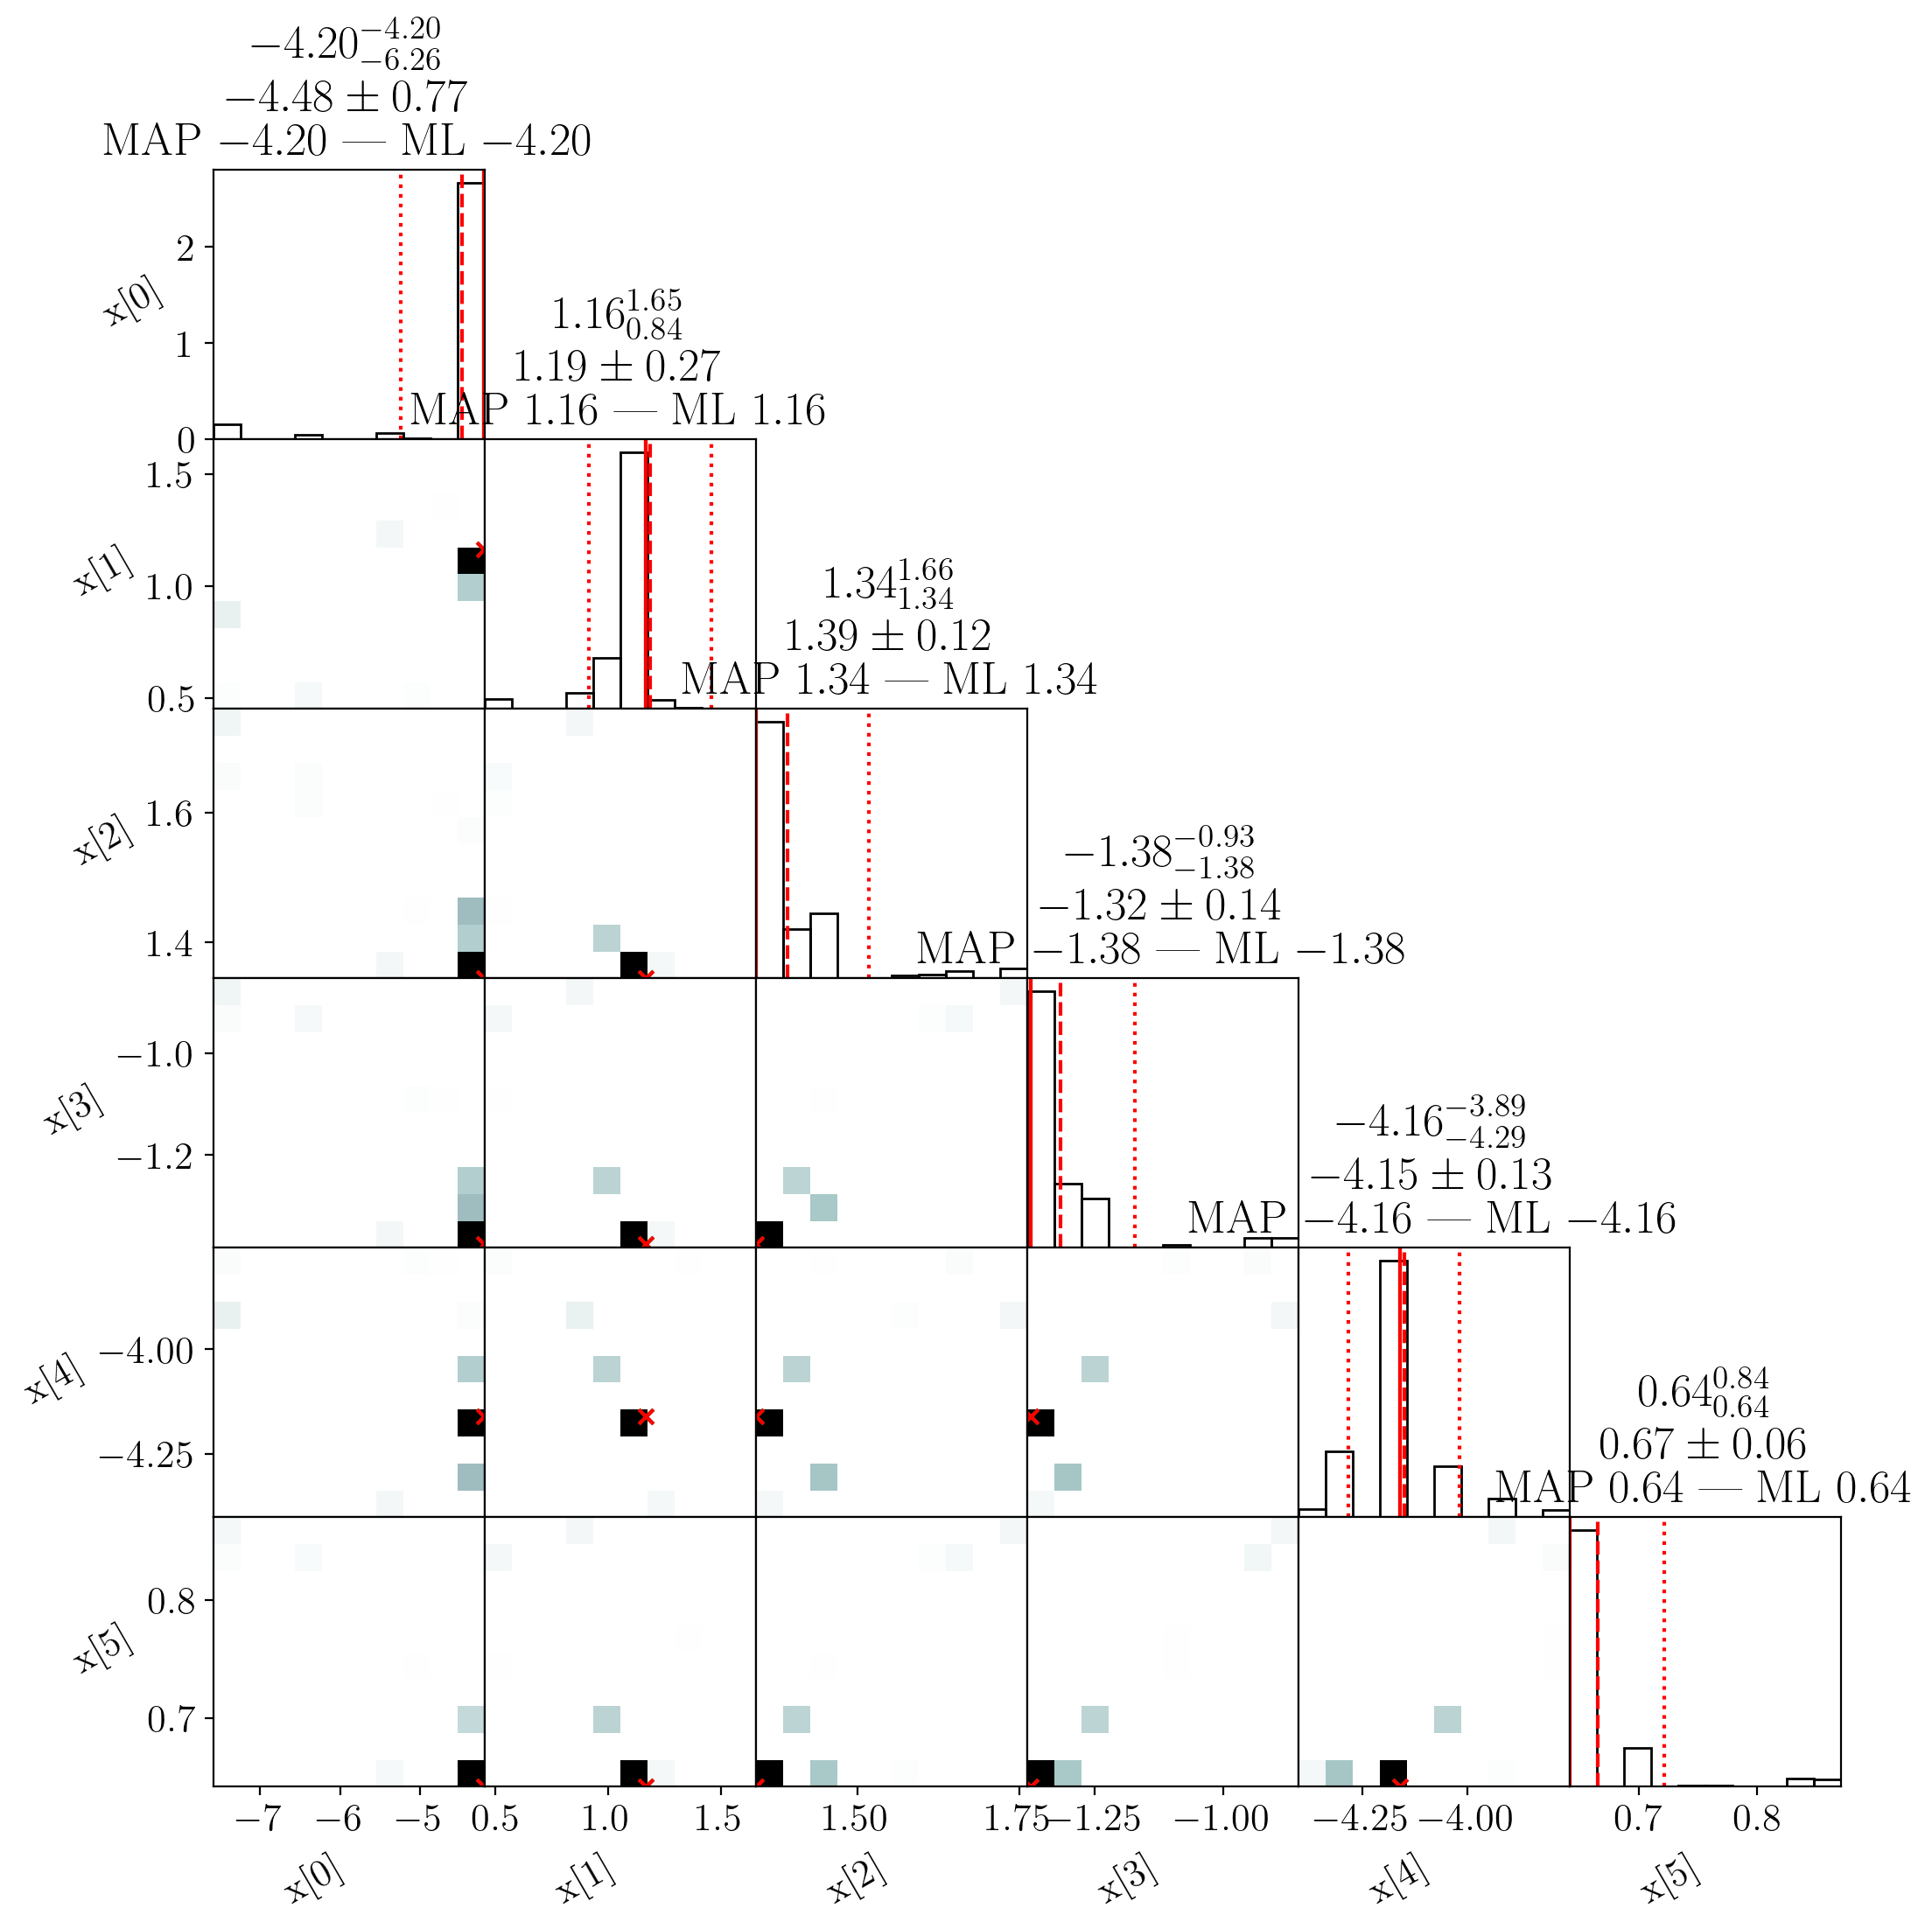

In [10]:
ns.plot_cornerplot(results)


In [18]:
samples = resample(key=random.PRNGKey(0),
                        samples=results.samples,
                        log_weights=results.log_dp_mean, # type: ignore
                        replace=True,) 
print(samples['x'].shape)

(5213, 6)


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the samples

(82, 50)


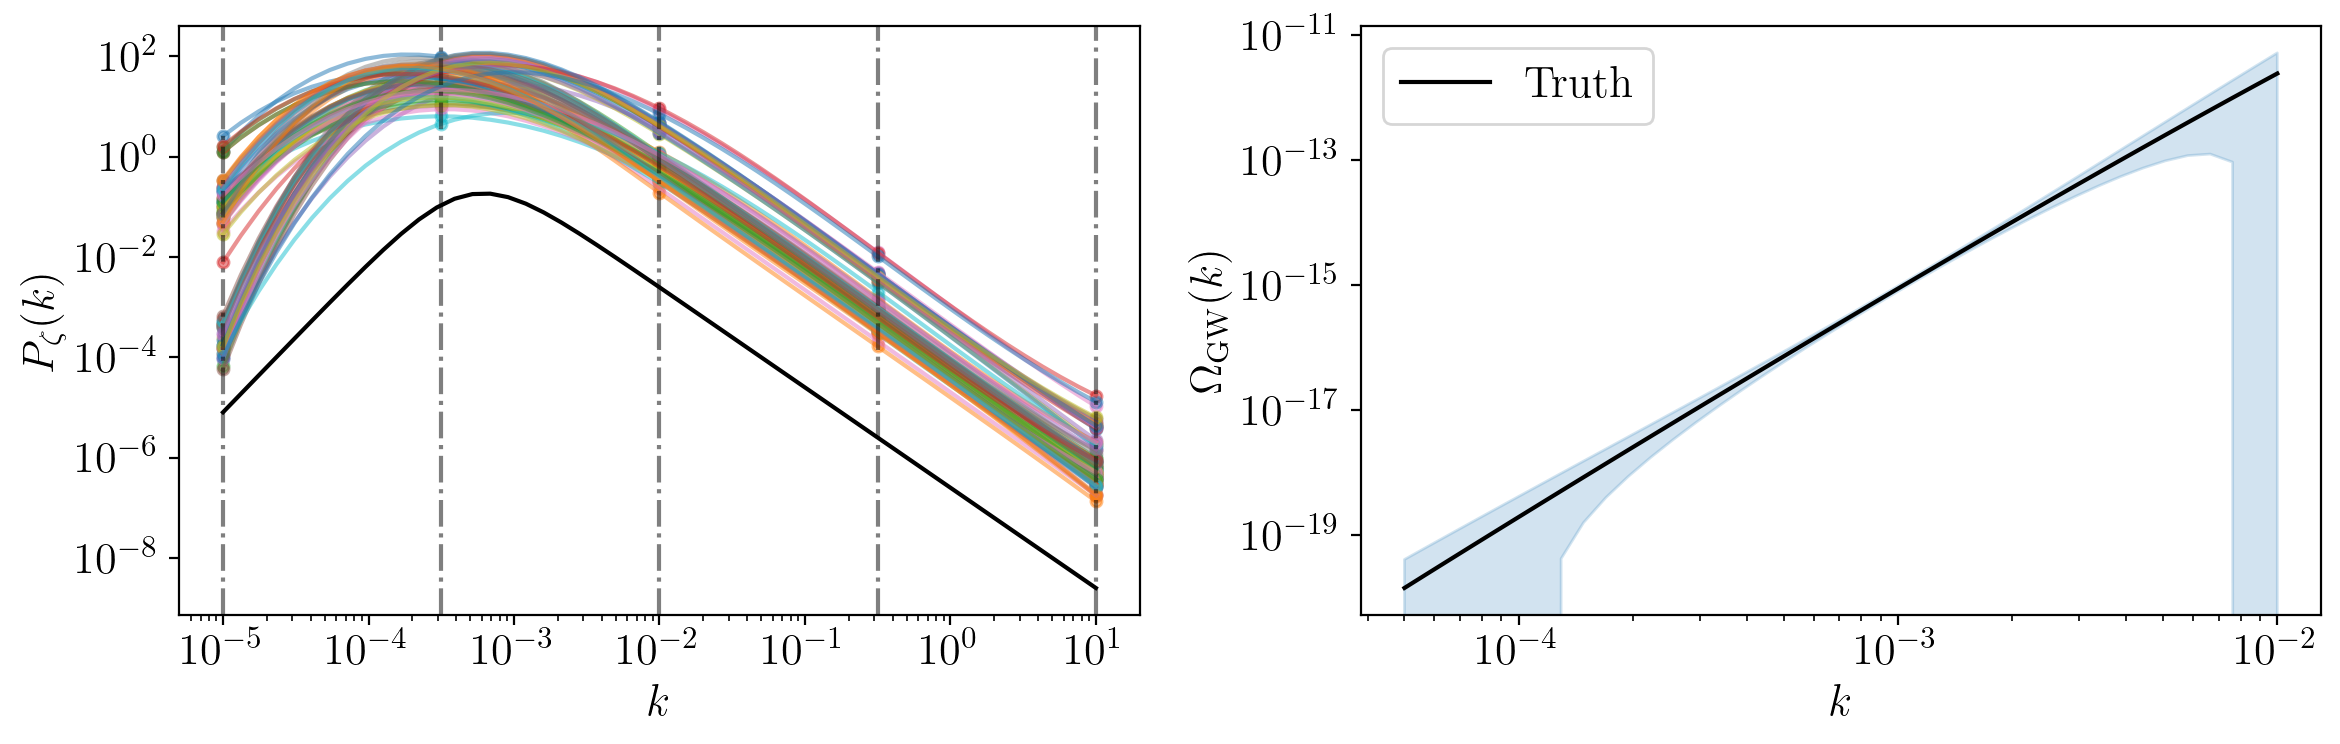

In [25]:
thin_factor = 64
samps = samples['x'][::thin_factor] 
ys = samps[:,:5]
kmaxs = samps[:,-1]
etaRs = 1/kmaxs
def omega_f(y,kmax,etaR):
    etaR = 1./kmax
    pz_interp = lambda k, kmax,etaR: spline_predict(x_train=nodes,y_train=y,x_pred=k)
    gwb = omgw_calculator(pz_interp,f,kmax,etaR)    
    return gwb
gwb_amps = vmap(omega_f,)(ys,kmaxs,etaRs)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(ys)
print(pz_amps.shape)
# gwb_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,gwb_calculator.omkij)
# print(gwb_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pzs in enumerate(pz_amps):
    ax1.loglog(p_arr,pzs,alpha=0.5)
    ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-5,1.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

# the dashed lines represent the spline node locations

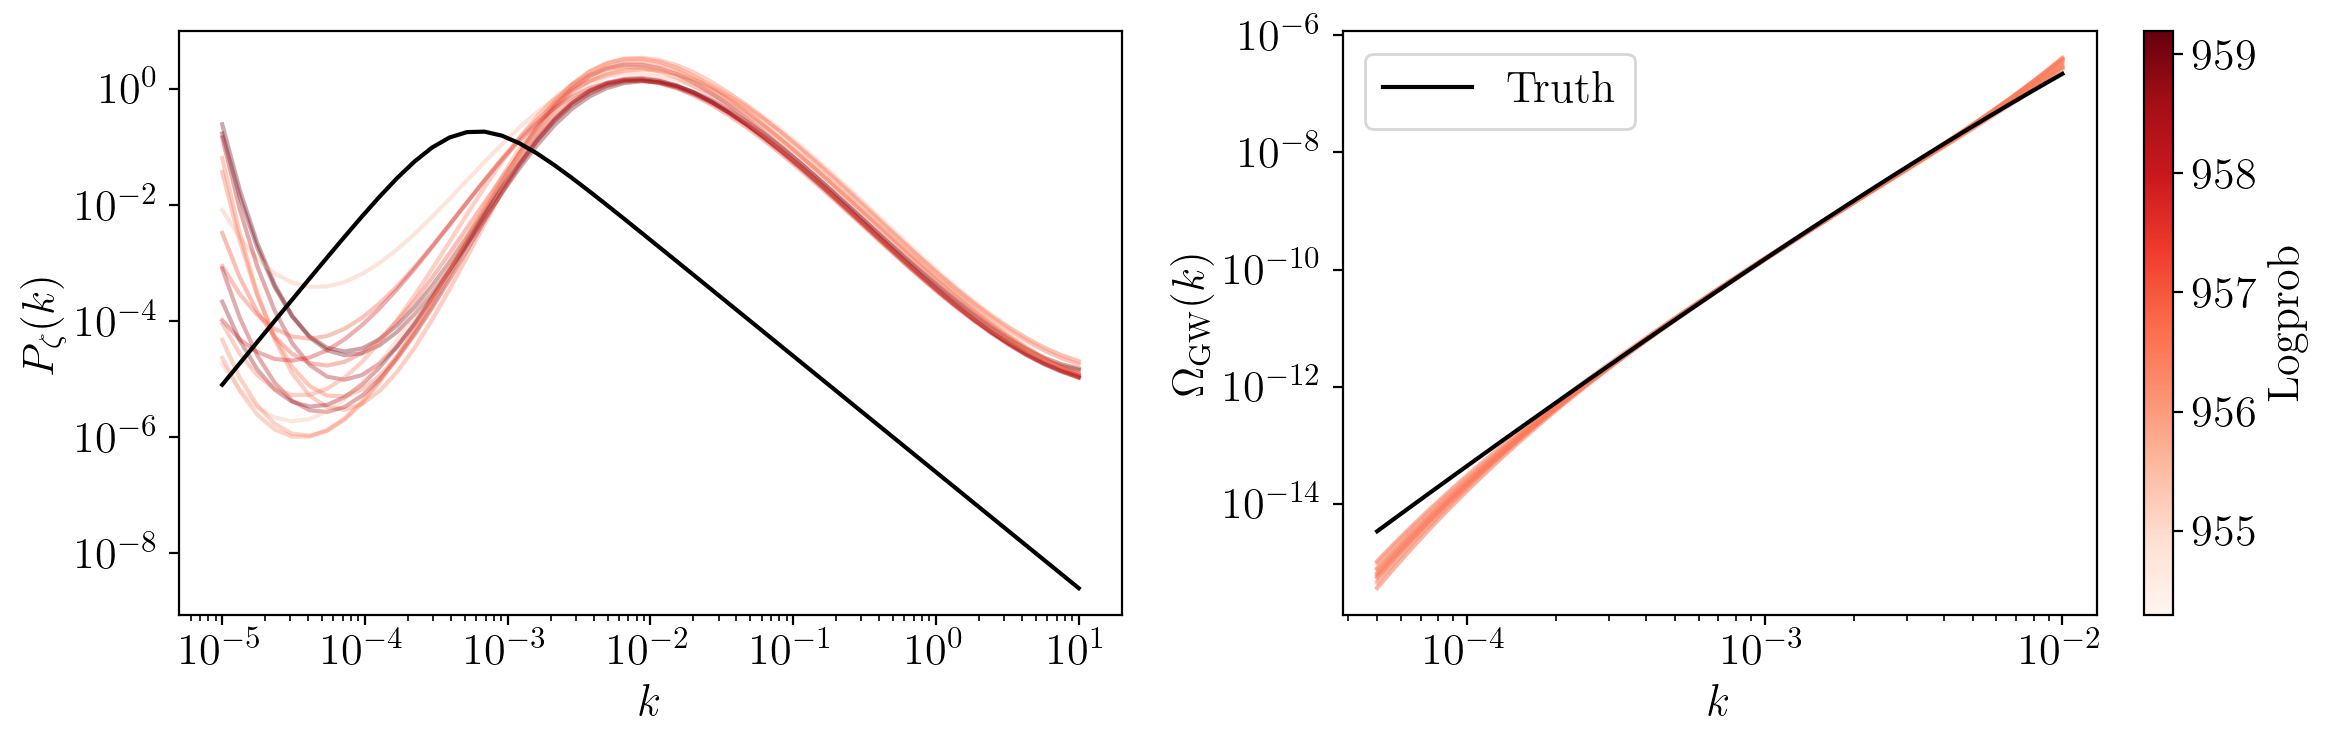

In [ ]:
### Plot the MC realisations with their logprob
cmap = matplotlib.colormaps['Reds']
ys = samples['y']
lp = -extras["potential_energy"][::thin_factor] # PE = -negative logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# pz_amps = vmap(ff,)(ys)
for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.35,color=cmap(cols[i]))
    # ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.35,color=cmap(cols[i]))
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-5,1.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax2,label='Logprob')
fig.tight_layout()

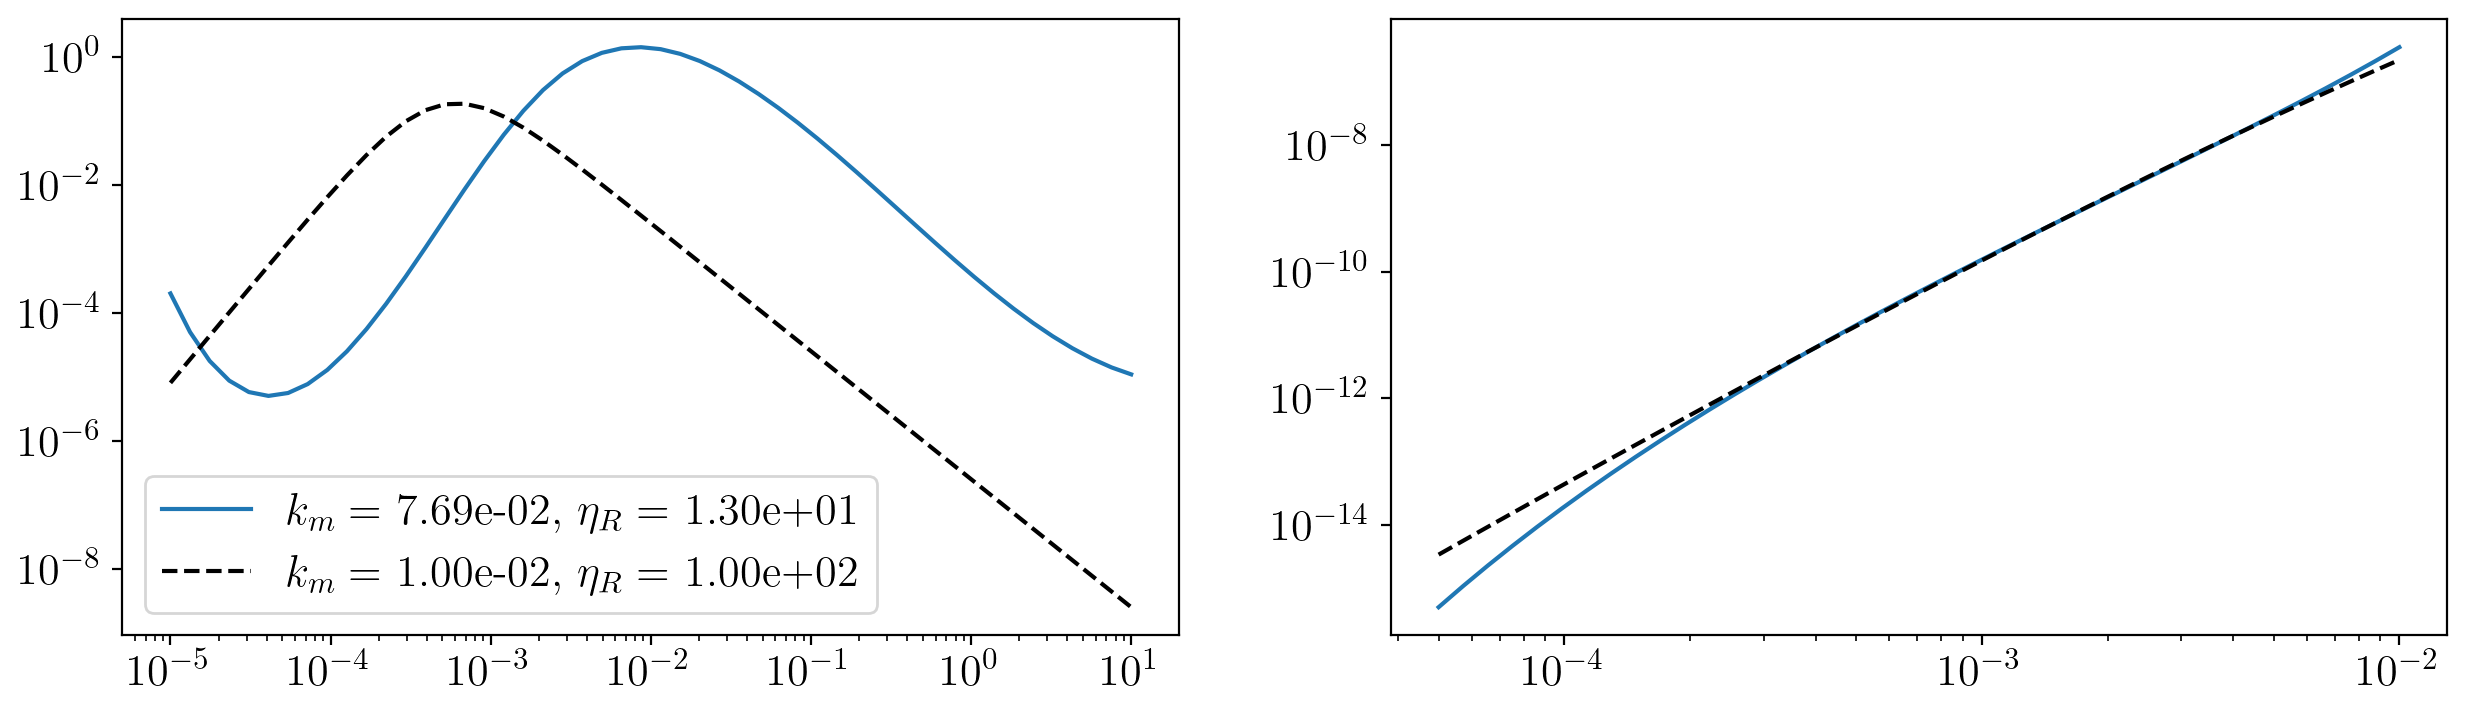

In [ ]:
idx = np.random.randint(0,len(ys))
ys, kmax, etar = samples['y'][idx], samples['kmax'][idx], samples['etaR'][idx]
pz_interp = lambda k, kmax, etaR: pz_model.spline(x=nodes,y=ys,k=k)
omgw_test = gwb_calculator(pz_interp,k_arr,kmax,etar)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.plot(p_arr,pz_interp(p_arr,kmax,etar),label=r'$k_m = $ {:.2e}, $\eta_R = $ {:.2e}'.format(kmax,etar))
kmax = 1e-2
etaR = 1./kmax
ax1.plot(p_arr,pz_amp,label=r'$k_m = $ {:.2e}, $\eta_R = $ {:.2e}'.format(kmax,etaR),color='k',ls='--')
ax2.plot(k_arr,omgw_test)
ax2.plot(k_arr,gwb_amp,color='k',ls='--')
for x in [ax1,ax2]:
    x.set(xscale='log',yscale='log')
ax1.legend()

#### Do an optimization instead of HMC sampling

In [ ]:
# from interpolation.model import optim_scipy_bh , optim_optax
# nodes = pz_model.log_k_nodes
# best_idx = jnp.argmin(extras['potential_energy'])
# worst_idx = jnp.argmax(extras['potential_energy'])
# print(samples['y'][worst_idx])
# x0 = samples['y'][best_idx]  
# print(x0)
# # x0 = -1.5*jnp.ones(5)
# best_params, _ = optim_scipy_bh(x0 = x0,loss = pz_model.loss,bounds=len(x0)*[(-7,1)],stepsize=0.2,niter=20) 
# # best_params, _ =  optim_optax(x0 = -1.5*jnp.ones(5), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.,y_low=-8.,y_high=-0.)
# print(best_params)
# pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
# # gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
# gwb_bf = pz_model.get_gwb_from_xy(x=nodes,y=best_params) #gwb_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,gwb_calculator.omkij)

In [ ]:
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# ax1.loglog(p_arr,pz_bf(p_arr),color='r')
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
# ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
# ax2.loglog(k_arr,gwb_bf,color='r',label='reconstructed')
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
# ax2.set(yscale='log',xscale='log')

# ax1.set_ylabel(r'$P_{\zeta}(k)$')
# ax1.set_xlabel(r'$k$')
# ax1.set_ylim(1e-5,1.)
# ax2.set_ylim(1e-4,1.)

# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
# ax2.set_xlabel(r'$k$')
# ax2.legend()
# for val in nodes:
#     ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
# ax1.scatter(10**(nodes),10**(best_params),color='r')
# fig.tight_layout()
